# Segmentando clientes

experimento colaborativo

## Resumen, explicación del experimento

- tomo datos hasta marzo para priobar en abril, último mes con caqtegorías completas
- uso bajas binarias (baja+1 y baja+2 vs continua)
- con todas las bajas de los tres meses y un sampleo pequeño de los continua calculo la **distancia random forest**
- reduzco las dimensiones con umap y calculo los clusters con dbscan
- obetngo centroides para cada cluster y busco los puntos reales más cercanos a los centroides
- calculo las distancias random forest a esos 6 puntos de todo el dataset - *los seis meses*
- calculo las distancias depués de pasarlos a umap, *hay que dividir por lotes problema de memoria*
- agrego las distancias calculadas al datset antes de calcular las medidas históricas
- comparo resultados contra el pipeline estandar

*Tomando codigo de los lunes (porque me llevo mejor con python)*

#### Configuración inicial

In [1]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
# %pip install umap
# %pip install umap-learn # en windows solo instalar umap-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer
from scipy.spatial import distance

In [3]:
base_path = 'E:/Users/Piquelin/Documents/Maestría_DataMining/Economia_y_finanzas/'
# base_path = '~/buckets/b1/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'

In [4]:
df_base = pd.read_csv(dataset_path + dataset_file, low_memory=False)

#### empiezo

In [5]:
# restrinjo hasta 202103 porque uso 202104 para el score y no quiero data leakage
# cuando entrene el último hay que poner hasta 202104
Xtrain = df_base[df_base['foto_mes']<=202103] 

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [6]:
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [7]:
np.random.seed(17) # semillas fija... primera para los bajas
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [8]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf.iloc[:,1:]) # saco numero de cliente

model = RandomForestClassifier(n_estimators=200, max_features=20, min_samples_leaf=400, random_state=17 )
model.fit(Xtrain_rf_imp, ytrain_rf)

RandomForestClassifier(max_features=20, min_samples_leaf=400, n_estimators=200,
                       random_state=17)

Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [9]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

E:\Users\Piquelin\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


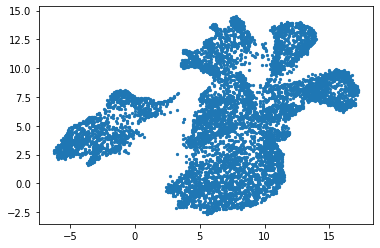

In [10]:
# Separo el fit del transform para mayor claridad
umap_rf = UMAP(
  n_components=2,
  n_neighbors=150,
  min_dist=0.6,
  metric="euclidean", #  precomputed no permite convertir nuevos puntos
  random_state=17,
).fit(md)

embedding_rf = umap_rf.embedding_

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], s=5, alpha=0.7)

In [11]:
# copio el modelo para poder correr pruebas sin ensuciar el original
model_copia = model

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

In [12]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model_copia.predict_proba(Xtrain_rf_imp)[:,class_index]

# acá clusterizo juego con eps y min_samples para un numero/distirbución que me guste de clusters
# se puede probar experimentar con esto
hdb = DBSCAN(eps=0.30, min_samples=10)
y = hdb.fit(embedding_rf)


Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

In [13]:
# Función para ubicar centroides en el grafico desde el umap y el dbscan
# util para gráfico y para medir distancia después

def centroides_punto(y, embedding_rf, sin_ruido=True):
    # Asignar las etiquetas de los clusters del DBSCAN
    labels = y.labels_
    
    # Crear un DataFrame con las etiquetas y los puntos
    df_clusters = pd.DataFrame(embedding_rf, columns=['x', 'y'])
    df_clusters['cluster'] = labels
    
    # Agrupar por cluster y calcular el centroide (media) de cada uno
    centroides = df_clusters.groupby('cluster').mean()

    # Cantidad de puntos por clúster
    cantidad = pd.Series(labels).value_counts()
    cantidad.index.rename('cluster', inplace=True)
    
    # Unir centroides con la cantidad de puntos por clúster
    centro_y_cantidad = pd.merge(centroides, cantidad, left_index=True, right_index=True)
    centro_y_cantidad.columns = ['centro_x', 'centro_y', 'count']
    
    # Filtrar ruido (clúster -1), si es necesario
    if sin_ruido:
        centro_y_cantidad = centro_y_cantidad[centro_y_cantidad['count'] > centro_y_cantidad.loc[-1, 'count']]
    
    # Encontrar el punto más cercano al centroide para cada clúster
    punto_mas_cercano = {}
    for cluster in centro_y_cantidad.index:
        # Filtrar los puntos que pertenecen al clúster actual
        puntos_cluster = df_clusters[df_clusters['cluster'] == cluster]
        
        # Coordenadas del centroide del clúster
        centroide = centro_y_cantidad.loc[cluster, ['centro_x', 'centro_y']].values
        
        # Calcular la distancia de cada punto al centroide
        distancias = distance.cdist(puntos_cluster[['x', 'y']], [centroide], metric='euclidean').flatten()
        
        # Obtener el índice del punto más cercano
        indice_cercano = np.argmin(distancias)
        
        # Guardar el punto más cercano al centroide
        punto_mas_cercano[cluster] = puntos_cluster.iloc[indice_cercano]

    indice_punto = []
    p_x = []
    p_y = []
    for i in punto_mas_cercano:
        indice_punto.append(punto_mas_cercano[i].name)
        p_x.append(punto_mas_cercano[i].x)
        p_y.append(punto_mas_cercano[i].y)

    centro_y_cantidad['indice_punto'] = indice_punto
    centro_y_cantidad['p_x'] = p_x
    centro_y_cantidad['p_y'] = p_y
    return centro_y_cantidad

# centro_y_cantidad = centroides_punto(y, embedding_rf, sin_ruido=True)


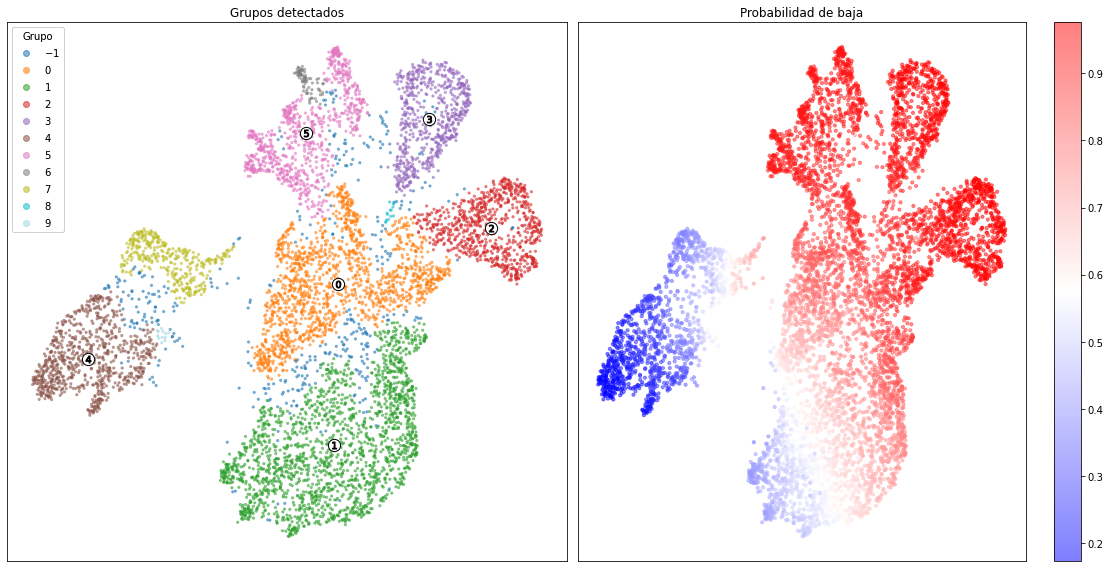

In [14]:
# función para graficar y entender la distribución y cantidades de los clusters
def grafico_clusters(y, embedding_rf):
    fig, axs = plt.subplots(1,2, figsize=(16,8))
    
    scatter = axs[0].scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab20', s=5, alpha=0.5)
    # produce a legend with the unique colors from the scatter
    legend1 = axs[0].legend(*scatter.legend_elements(),
                        loc="upper left", title="Grupo")
    axs[0].add_artist(legend1)
    axs[0].set_title('Grupos detectados')
    
    prop = axs[1].scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja, s=10,  cmap='bwr', alpha=0.5)
    fig.colorbar(prop, ax=axs[1] )
    axs[1].set_title('Probabilidad de baja')
    
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    centers = centroides_punto(y, embedding_rf, sin_ruido=True)
    
    # Draw white circles at cluster centers
    axs[0].scatter(
        centers['centro_x'],
        centers['centro_y'],
        marker="o",
        c="white",
        alpha=1,
        s=150,
        edgecolor="k",
    )
    
    for i, c in enumerate(centers.T):
    
        axs[0].scatter(centers.T[c]['centro_x'], centers.T[c]['centro_y'], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
    fig.tight_layout()
    #fig.savefig('clusters.png', dpi=92)
    plt.show()

grafico_clusters(y, embedding_rf)

## NUEVO
ahora voy a calcular la distancia de cada punto a los centroides y agregarlo al dataset original 

In [15]:
# acá calculo la distancia random forest (en el modelo que entrené antes)
# la diferencia es que permite dos grupos de puntos

def calcular_proximidad_centroides(model, puntos_nuevos, centroides):
    """
    Calcula la proximidad basada en bosques aleatorios entre puntos nuevos y los centroides.

    :param model: Modelo de bosque aleatorio (RandomForest) ya entrenado
    :param puntos_nuevos: DataFrame o array con los puntos nuevos (n_rows, n_dims)
    :param centroides: DataFrame o array con los centroides (6, n_dims)
    
    :return: DataFrame con la proximidad entre cada punto nuevo y cada uno de los 6 centroides
    """
    
    # Aplicar el modelo a los puntos nuevos y los centroides para obtener las hojas terminales
    terminales_nuevos = model.apply(puntos_nuevos)
    terminales_centroides = model.apply(centroides)
    
    # Obtener el número de árboles en el modelo
    nTrees = terminales_nuevos.shape[1]
    
    # Inicializar la matriz de proximidad
    proximidad = np.zeros((puntos_nuevos.shape[0], centroides.shape[0]))
    
    # Calcular la proximidad entre cada punto nuevo y cada centroide
    for i in range(nTrees):
        # Compara los terminales de los puntos nuevos con los terminales de los centroides para cada árbol
        iguales = np.equal.outer(terminales_nuevos[:, i], terminales_centroides[:, i])
        proximidad += iguales
   
    # Normalizar por el número de árboles
    proximidad = proximidad / nTrees

    return proximidad.max() - proximidad


In [16]:
# Encapsulo la función anterior preparando el dataset general

def distancias_para_todos(df_base, centroides, imp_mean, model):
    df_base = df_base.drop("clase_ternaria", axis=1)
    todos_los_puntos = imp_mean.transform(df_base.iloc[:,1:]) # saco numero de cliente
        
    centroides = imp_mean.transform(centroides.iloc[:,1:]) # saco numero de cliente
    distancias_centroides = calcular_proximidad_centroides(model, todos_los_puntos, centroides)
    return distancias_centroides


In [17]:
# Acá encapsulo para los lotes de umap

def distancias_para_todos_u(todos_los_puntos, centroides, imp_mean, model):
    #df_base = df_base.drop("clase_ternaria", axis=1)
    #todos_los_puntos = imp_mean.transform(df_base.iloc[:,1:]) # saco numero de cliente
        
    centroides = imp_mean.transform(centroides.iloc[:,1:]) # saco numero de cliente
    distancias_centroides = calcular_proximidad_centroides(model, todos_los_puntos, centroides)
    return distancias_centroides


In [18]:
# finalmente calculo el primer set de distancias randomf forest con los puntos más cercanos a los centroides

df_clust = centroides_punto(y, embedding_rf, sin_ruido=True)
centroides = Xtrain.loc[df_clust['indice_punto']]
distancias_centroides = distancias_para_todos(df_base, centroides, imp_mean, model)

In [19]:
# armos funciones de loop y lotes para procesar todo el dataset.
# hay que ver que onda cuano queramos correr más meses

def restart_line():
    sys.stdout.write('\r')
    sys.stdout.flush()

def generar_lotes(puntos, tamaño_lote):
    """
    Divide los puntos en lotes más pequeños para procesar.
    
    :param puntos: Array o DataFrame con todos los puntos
    :param tamaño_lote: Tamaño de cada lote
    :yield: Un lote de puntos
    """
    for i in range(0, len(puntos), tamaño_lote):
        yield puntos[i:i + tamaño_lote]


def calcular_distancias(puntos, centroides, metric='euclidean'):
    """
    Calcula las distancias entre un array de puntos y un conjunto de centroides.

    :param puntos: Array o DataFrame con los puntos (n_puntos, n_dims)
    :param centroides: DataFrame con los centroides (n_centroides, n_dims)
    :param metric: Métrica de distancia (por defecto es 'euclidean')
    
    :return: DataFrame con las distancias de cada punto a cada centroide
    """
    # Calcular las distancias entre cada punto y los centroides
    distancias = distance.cdist(puntos, centroides.values, metric=metric)
    
    # Crear un DataFrame con las distancias calculadas
    df_distancias = pd.DataFrame(distancias, columns=[f'centroide_{i}' for i in range(centroides.shape[0])])
    
    return df_distancias
    

def distancias_para_todos_lotes(df_base, df_clust, imp_mean, model, umap_rf, tamaño_lote=10000):
    """
    Calcula las distancias por lotes y aplica UMAP a cada lote de distancias.

    :param df_base: DataFrame base de puntos
    :param centroides: DataFrame con los centroides
    :param imp_mean: Objeto de imputación para transformar los datos
    :param model: Modelo de Random Forest entrenado
    :param umap_rf: Modelo UMAP ya entrenado
    :param tamaño_lote: Tamaño de cada lote para el procesamiento
    
    :return: Array con todas las distancias transformadas por UMAP
    """
    df_base = df_base.drop("clase_ternaria", axis=1)
    todos_los_puntos = imp_mean.transform(df_base.iloc[:, 1:])  # Sin número de cliente
    #centroides = imp_mean.transform(centroides.iloc[:, 1:])  # Sin número de cliente
    
    # Array donde se almacenarán todas las distancias reducidas con UMAP
    distancias_umap_total = []

    cont = 0
    total = len(df_base.iloc[:,:-1])
    p_centro = df_clust[['p_x', 'p_y']]
        
    # Procesar los puntos en lotes
    for lote_puntos in generar_lotes(todos_los_puntos, tamaño_lote):

        cont = cont + tamaño_lote
        perc = (cont/total)*100
        #print(f'porcentaje:{perc:,.0f}') 
            
        sys.stdout.write(f'porcentaje:{perc:,.01f}')
        sys.stdout.flush()
        restart_line()


        #muestra = df_base.sample(1000)
        
        dist_p_umap = distancias_para_todos_u(lote_puntos, Xtrain_rf, imp_mean, model) # 7232 dim
        p_umap = umap_rf.transform(dist_p_umap) # dos dim
        
        distancias_umap_lote = calcular_distancias(p_umap, p_centro)

        # Almacenar el resultado del lote
        distancias_umap_total.append(distancias_umap_lote)
    
    # Concatenar todos los resultados en un solo array o DataFrame
    return np.vstack(distancias_umap_total)




#### Esto tarda mucho

In [20]:
dist_calculada = distancias_para_todos_lotes(df_base, df_clust, imp_mean, model, umap_rf, tamaño_lote=10000)

In [27]:
range(dist_calculada.shape[1])

range(0, 6)

In [32]:
cols =[]
for col in range(dist_calculada.shape[1]):
    cols.append(f'umap_clust_{col}')



In [33]:
dist_calculada_umap = pd.DataFrame(dist_calculada, columns=cols)


In [34]:
dist_calculada_umap.to_csv('dist_calculada_umap.csv')

In [37]:
cols_rf =[]
for col in range(distancias_centroides.shape[1]):
    cols_rf.append(f'umap_clust_{col}')


In [38]:
dist_calculada_rf = pd.DataFrame(distancias_centroides, columns=cols_rf)
dist_calculada_rf.to_csv('dist_calculada_rf.csv')